In [3]:
%matplotlib inline

import random
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import os
import torchaudio
from torchaudio.transforms import MelSpectrogram
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
cudnn.benchmark = True
plt.ion()   # interactive mode


N_SAMPLES=25500 #fixed length
label_list=['808s','Claps','Closed Hats','Crashes & Cymbals','Extras','FX','Kicks','Open Hats','Percs','Snares','Vox']
data_dir= './data'


paths=[]
labels=[]
for root, subdirs, files in os.walk(data_dir):
    if len(files)>0:
        label=os.path.basename(os.path.normpath(root))
        if label in label_list:
            for file in files:
                if (file[-3:]=='wav' or file[-3:]=='WAV') and file[0]!='.' and  os.path.getsize(os.path.join(root, file)) >1024*10:
                    labels.append(label)
                    paths.append(os.path.join(root, file))

c = list(zip(paths, labels))
random.Random(42).shuffle(c)
paths, labels = zip(*c)

val_paths=paths[:len(paths)//10]
val_labels=labels[:len(paths)//10]

train_paths=paths[len(paths)//10:]
train_labels=labels[len(paths)//10:]
print(len(train_paths),len(val_paths))

class AudioDataset(Dataset):
    
    def __init__(self, mypaths, mylabels,transform=None):
        self.paths=mypaths
        self.labels=mylabels
        self.n_samples=len(mypaths)
        self.label_list=label_list
    def __getitem__(self, index):
        waveform, sample_rate = torchaudio.load(self.paths[index], normalize=True)
        waveform = torch.mean(waveform, dim=0).unsqueeze(0) #mono
        #
        # to fixed length
        target = torch.zeros(1, N_SAMPLES)
        target[:,:min(waveform.shape[1],N_SAMPLES) ] = waveform[:,:min(waveform.shape[1],N_SAMPLES)]
        waveform=target
        
        #mel, expand for resnet to 3 channels
        mel = MelSpectrogram(sample_rate)(waveform)

        return  mel.expand(3,-1,-1), torch.tensor(self.label_list.index(self.labels[index]))

   
    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


4838 537


In [2]:
audio_datasets = {'train': AudioDataset(train_paths,train_labels),'val': AudioDataset(val_paths,val_labels)}
dataloaders = {x: torch.utils.data.DataLoader(audio_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(audio_datasets[x]) for x in ['train', 'val']}
class_names = label_list

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase],position=0,leave=True):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) #classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
 #                      num_epochs=25)

Epoch 0/24
----------


  0%|                                                                                         | 0/1210 [00:00<?, ?it/s]C:\Users\nguye\anaconda3\envs\envDL\lib\site-packages\torchaudio\functional\functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:32<00:00, 37.21it/s]


train Loss: 1.1824 Acc: 0.6166


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 60.22it/s]


val Loss: 1.6339 Acc: 0.7114

Epoch 1/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:29<00:00, 41.23it/s]


train Loss: 0.8341 Acc: 0.7305


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 78.25it/s]


val Loss: 0.9050 Acc: 0.7747

Epoch 2/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:28<00:00, 42.54it/s]


train Loss: 0.7498 Acc: 0.7590


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 74.39it/s]


val Loss: 2.1442 Acc: 0.4767

Epoch 3/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:28<00:00, 42.55it/s]


train Loss: 0.6756 Acc: 0.7792


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 76.37it/s]


val Loss: 1.9052 Acc: 0.4860

Epoch 4/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:28<00:00, 41.74it/s]


train Loss: 0.6247 Acc: 0.7921


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 66.04it/s]


val Loss: 0.7296 Acc: 0.7821

Epoch 5/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:29<00:00, 41.48it/s]


train Loss: 0.5883 Acc: 0.8049


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 72.53it/s]


val Loss: 2.4679 Acc: 0.3613

Epoch 6/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:29<00:00, 40.72it/s]


train Loss: 0.5207 Acc: 0.8317


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 74.61it/s]


val Loss: 3.0410 Acc: 0.2048

Epoch 7/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:30<00:00, 40.29it/s]


train Loss: 0.3955 Acc: 0.8677


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 70.41it/s]


val Loss: 2.5991 Acc: 0.3054

Epoch 8/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:28<00:00, 41.87it/s]


train Loss: 0.3542 Acc: 0.8793


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 71.32it/s]


val Loss: 3.6857 Acc: 0.1415

Epoch 9/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:29<00:00, 40.70it/s]


train Loss: 0.3334 Acc: 0.8867


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 80.44it/s]


val Loss: 1.7816 Acc: 0.4730

Epoch 10/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:28<00:00, 41.92it/s]


train Loss: 0.3267 Acc: 0.8878


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 69.72it/s]


val Loss: 2.8834 Acc: 0.2831

Epoch 11/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:29<00:00, 40.98it/s]


train Loss: 0.3055 Acc: 0.8969


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 72.32it/s]


val Loss: 4.5739 Acc: 0.1750

Epoch 12/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:30<00:00, 39.83it/s]


train Loss: 0.3087 Acc: 0.8967


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 71.47it/s]


val Loss: 2.6443 Acc: 0.3371

Epoch 13/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:32<00:00, 37.02it/s]


train Loss: 0.2934 Acc: 0.8987


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 58.20it/s]


val Loss: 2.7219 Acc: 0.3501

Epoch 14/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:34<00:00, 35.07it/s]


train Loss: 0.2699 Acc: 0.9091


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 59.40it/s]


val Loss: 1.5214 Acc: 0.5791

Epoch 15/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:34<00:00, 35.05it/s]


train Loss: 0.2800 Acc: 0.9066


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 57.63it/s]


val Loss: 2.3150 Acc: 0.3985

Epoch 16/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:34<00:00, 35.07it/s]


train Loss: 0.2719 Acc: 0.9099


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 60.45it/s]


val Loss: 1.6894 Acc: 0.4991

Epoch 17/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:34<00:00, 34.79it/s]


train Loss: 0.2693 Acc: 0.9074


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 56.50it/s]


val Loss: 1.6411 Acc: 0.5140

Epoch 18/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:33<00:00, 35.97it/s]


train Loss: 0.2631 Acc: 0.9128


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 57.76it/s]


val Loss: 5.3285 Acc: 0.1192

Epoch 19/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:35<00:00, 34.03it/s]


train Loss: 0.2646 Acc: 0.9107


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 57.25it/s]


val Loss: 4.6419 Acc: 0.1601

Epoch 20/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:36<00:00, 33.41it/s]


train Loss: 0.2694 Acc: 0.9111


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 54.66it/s]


val Loss: 1.9015 Acc: 0.4693

Epoch 21/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:36<00:00, 33.04it/s]


train Loss: 0.2649 Acc: 0.9124


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 52.92it/s]


val Loss: 2.0617 Acc: 0.4804

Epoch 22/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:33<00:00, 36.30it/s]


train Loss: 0.2706 Acc: 0.9097


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 71.61it/s]


val Loss: 1.7185 Acc: 0.5028

Epoch 23/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:30<00:00, 39.78it/s]


train Loss: 0.2617 Acc: 0.9130


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:02<00:00, 63.64it/s]


val Loss: 2.8783 Acc: 0.3333

Epoch 24/24
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:30<00:00, 39.67it/s]


train Loss: 0.2610 Acc: 0.9113


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 71.72it/s]

val Loss: 1.7817 Acc: 0.5009

Training complete in 14m 4s
Best val Acc: 0.782123


In [12]:
from torchsummary import summary

summary(model_ft, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
#load model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) #classes

model_ft = model_ft.to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

In [46]:
dataloaders = {x: torch.utils.data.DataLoader(audio_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=0)
              for x in ['train', 'val']}
def get_X(model, num_samples=1000):
    X=[]
    Y=[]
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(dataloaders['train']),position=0,leave=True):
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #print(outputs[j].shape)
                X.append(outputs[j].cpu().numpy())
                Y.append(labels[j].cpu().numpy())
                if images_so_far ==num_samples:
                    
                    model.train(mode=was_training)
                    return np.array(X),np.array(Y)
        
X,labels=get_X(model_ft,num_samples=1000)
assert([label_list.index(i) for i in train_labels[:1000]]==labels).all()

249it [00:03, 64.40it/s]


<Figure size 432x288 with 0 Axes>

2.0117237891133954
The 100 th loop cost: 10.807233175263455, computation time: 3.6631383895874023
The 200 th loop cost: 0.4896793561441531, computation time: 7.247264385223389
The 300 th loop cost: 0.41622510782427413, computation time: 10.769378423690796
The 400 th loop cost: 0.40093069212550114, computation time: 14.408013820648193
The 500 th loop cost: 0.39643862241121264, computation time: 17.94463038444519
The 600 th loop cost: 0.39424002055193125, computation time: 21.462244272232056
The 700 th loop cost: 0.39292290236291777, computation time: 25.037367820739746
The 800 th loop cost: 0.39202646858662094, computation time: 28.561983108520508
The 900 th loop cost: 0.391379918729662, computation time: 32.071595430374146
The 1000 th loop cost: 0.3908849079259799, computation time: 35.60621237754822


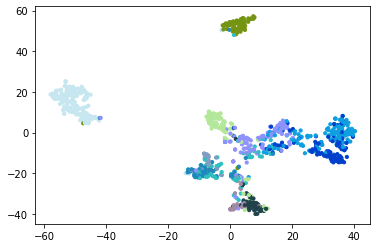

In [42]:
from tsne import tsne

Y = tsne(X, low_dim=2, perplexity=40.0)
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1],10,color_labels)
plt.show()

1.384708674876239
The 100 th loop cost: 12.877083549470989, computation time: 3.6461358070373535
The 200 th loop cost: 0.8012271236272189, computation time: 7.204756259918213
The 300 th loop cost: 0.6297215775239171, computation time: 10.762877464294434
The 400 th loop cost: 0.576915410585803, computation time: 14.350502967834473
The 500 th loop cost: 0.5591414706294133, computation time: 18.035645961761475
The 600 th loop cost: 0.5500218847499507, computation time: 21.617270946502686
The 700 th loop cost: 0.544400071755773, computation time: 25.173892736434937
The 800 th loop cost: 0.5404918844311308, computation time: 28.681004285812378
The 900 th loop cost: 0.5376235126669854, computation time: 32.18111491203308
The 1000 th loop cost: 0.5353822797851058, computation time: 35.694727659225464


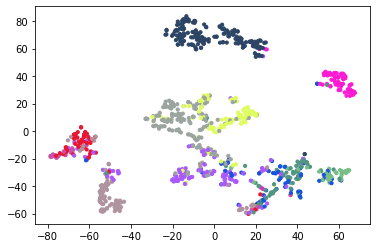

In [47]:
from tsne import tsne

Y = tsne(X, low_dim=2, perplexity=15.0)

colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1],10,color_labels)
plt.show()

In [71]:
Y[:,0].tofile('points_2d_x.csv', sep = ',')
Y[:,1].tofile('points_2d_y.csv', sep = ',')

#10min
# todo Add in pd df x,y,label_num,label_name,path columns
#save into csv 

#15min
#load points in d3
#10min
#add colors based on label
#10
#add audio interaction preview
#add on hover zoom and on hover display class and name


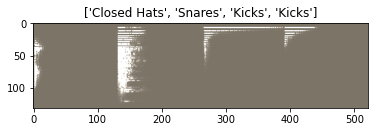

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
#torch.save(model_ft.state_dict(), './resnet18')